# Fundamental Matrix Estimation, Camera Calibration, Triangulation (Python)
## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Fundamental Matrix Estimation, Camera Calibration, Triangulation section of MP 3. We outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- You will need [GUI backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to enable interactive plots in `matplotlib`.
- `numpy`
- `PIL`

#### Common imports

In [21]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

#### Part (1)

In [23]:
def get_residual(F, p1, p2):
    """
    Function to compute the residual average residual on frame 2
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    """
    P1 = np.c_[p1, np.ones((p1.shape[0],1))].transpose()
    P2 = np.c_[p2, np.ones((p2.shape[0],1))].transpose()
    L2 = np.matmul(F, P1).transpose()
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis = 1)
    return np.mean(np.square(pt_line_dist))

def plot_fundamental(ax, F, p1, p2, I):
    """
    Function to display epipolar lines and corresponding points
    param: F (3x3): fundamental matrix: (pt in frame 2).T * F * (pt in frame 1) = 0
    param: p1 (Nx2): 2d points on frame 1
    param: p2 (Nx2): 2d points on frame 2
    param: I: frame 2
    """
    N = p1.shape[0]
    P1 = np.c_[p1, np.ones((N,1))].transpose()
    P2 = np.c_[p2, np.ones((N,1))].transpose()
    L2 = np.matmul(F, P1).transpose() # transform points from 

    # the first image to get epipolar lines in the second image
    L2_norm = np.sqrt(L2[:,0]**2 + L2[:,1]**2)
    L2 = L2 / L2_norm[:,np.newaxis]
    pt_line_dist = np.multiply(L2, P2.T).sum(axis=1)
    closest_pt = p2 - (L2[:,0:2]*pt_line_dist[:,np.newaxis])

    # Find endpoints of segment on epipolar line (for display purposes).
    # offset from the closest point is 10 pixels
    pt1 = closest_pt - np.c_[L2[:,1], -L2[:,0]]*10 
    pt2 = closest_pt + np.c_[L2[:,1], -L2[:,0]]*10

    # Display points and segments of corresponding epipolar lines.
    # You will see points in red corsses, epipolar lines in green 
    # and a short cyan line that denotes the shortest distance between
    # the epipolar line and the corresponding point.
    ax.set_aspect('equal')
    ax.imshow(np.array(I))
    ax.plot(p2[:,0],p2[:,1],  '+r')
    ax.plot([p2[:,0], closest_pt[:,0]],[p2[:,1], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')

In [25]:
# write your code here for part estimating essential matrices
def fit_fundamental(p1, p2):
    """
    Desciption: Solves for the fundamental matrix using the matches with unnormalized method.
    Params: 
        p1 (Nx2): 2d points on frame 1
        p2 (Nx2): 2d points on frame 2
    Returns:
        F_rank2: fundamental matrix where rank-2 constraint has been imposed
    """
    assert len(p1) == len(p2) >= 8
    
    A = np.empty((len(p1), 9))
    for i in range(len(p1)):
        u, v = p1[i]
        ud, vd = p2[i]

        A[i] = [ud * u, ud * v, ud, vd * u, vd * v, vd, u, v, 1]
    
    #svd composition
    U, S, V = np.linalg.svd(A)

    #reshape the min singular value into a 3 by 3 matrix
    F = np.reshape(V[-1, :], (3, 3))

    #enforce rank-2
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F_rank2 = U @ np.diag(S) @ V

    return F_rank2


def fit_fundamental_normalized(p1, p2):
    """
    Desciption: Solves for the fundamental matrix using the matches with normalized method.
    Params: 
        p1 (Nx2): 2d points on frame 1
        p2 (Nx2): 2d points on frame 2
    Returns:
        F_rank2: fundamental matrix where rank-2 constraint has been imposed
    """
    assert len(p1) == len(p2) >= 8
    
    # normalize p1
    p1_normalized = (p1 - p1.mean(axis=0)) / p1.std(axis=0)
    T = np.eye(3)
    T[:2, -1] -= p1.mean(axis=0)
    T[:2, :] /= p1.std(axis=0)[:, np.newaxis]

    # normalize p2
    p2_normalized = (p2 - p2.mean(axis=0)) / p2.std(axis=0)
    Td = np.eye(3)
    Td[:2, -1] -= p2.mean(axis=0)
    Td[:2, :] /= p2.std(axis=0)[:, np.newaxis]

    # construct least square problem
    A = np.empty((len(p1_normalized), 9))
    for i in range(len(p1_normalized)):
        u, v = p1_normalized[i]
        ud, vd = p2_normalized[i]

        A[i] = [ud * u, ud * v, ud, vd * u, vd * v, vd, u, v, 1]
    
    #svd composition
    U, S, V = np.linalg.svd(A)

    #reshape the min singular value into a 3 by 3 matrix
    F_normalized = np.reshape(V[-1, :], (3, 3))

    #enforce rank-2
    U, S, V = np.linalg.svd(F_normalized)
    S[-1] = 0
    F_normalized_rank2 = U @ np.diag(S) @ V

    # return to the original units
    F_rank2 = Td.T @ F_normalized_rank2 @ T

    return F_rank2


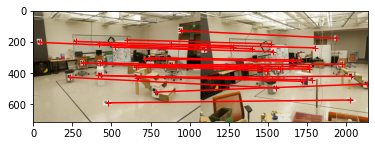

In [27]:
# Fundamental matrix estimation
name = 'lab' 
# You also need to report results for name = 'lab'
# name = 'lab'

I1 = Image.open('./{:s}1.jpg'.format(name))
I2 = Image.open('./{:s}2.jpg'.format(name))
matches = np.loadtxt('./{:s}_matches.txt'.format(name))
N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.size[1],I1.size[0]*2,3))
I3[:,:I1.size[0],:] = I1;
I3[:,I1.size[0]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.size[0],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))


lab: residual in frame 2 (non-normalized method) =  6.567091502185167
lab: residual in frame 1 (non-normalized method) =  9.76065542496813
lab: residual combined   (non-normalized method) =  8.163873463576648


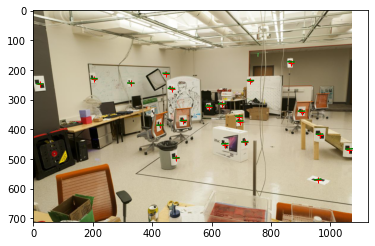

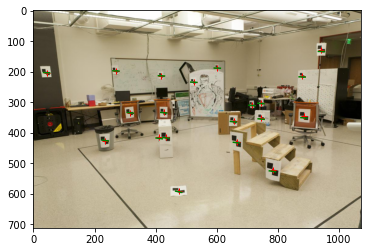

In [29]:
# non-normalized method
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]

F = fit_fundamental(pt1_2d, pt2_2d) # <YOUR CODE>

v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (non-normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (non-normalized method) = '.format(name), v1)
print('{:s}: residual combined   (non-normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
plt.savefig('./{:s}2_unnormalized.jpg'.format(name))
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
plt.savefig('./{:s}1_unnormalized.jpg'.format(name))

lab: residual in frame 2 (normalized method) =  0.5497313255920988
lab: residual in frame 1 (normalized method) =  0.5833496860083314
lab: residual combined   (normalized method) =  0.5665405058002151


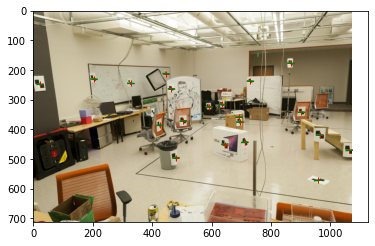

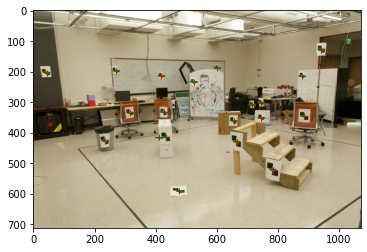

In [31]:
# normalized method
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]

F = fit_fundamental_normalized(pt1_2d, pt2_2d) # <YOUR CODE>
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (normalized method) = '.format(name), v1)
print('{:s}: residual combined   (normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
plt.savefig('./{:s}2_normalized.jpg'.format(name))
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
plt.savefig('./{:s}1_normalized.jpg'.format(name))

#### Part (2)

In [33]:
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

def camera_calibration(points_2d, points_3d):
    """
    Descriptions: compute camera matrix
    Parameters:
        points_2d: np.ndarray with shape (N, 3), where each row stands for a 2d homogeneous coordinate in the image frame
        points_3d: np.ndarray with shape (N, 4), where each row stands for a corresponding 3d homogeneous coordinate in the world frame
    Returns:
        P: np.ndarray with shape (3, 4), the estimated camera projection matrix
    """
    assert len(points_2d) == len(points_3d) >= 6
    
    # construct Ap = 0
    A = np.empty((2 * len(points_2d), 12))
    for i in range(len(points_2d)):
        x, y = points_2d[i]
        pt_3d = np.append(points_3d[i], 1)
        A[2*i] = np.concatenate([np.zeros(4), pt_3d, -y * pt_3d], axis=0)
        A[2*i+1] = np.concatenate([pt_3d, np.zeros(4), -x * pt_3d], axis=0)
    
    # svd composition
    U, S, V = np.linalg.svd(A)

    # reshape the min singular value into a 3 by 4 matrix
    P = np.reshape(V[-1, :], (3, 4))
    
    return P

In [35]:
# Load 3D points, and their corresponding locations in 
# the two images.
pts_3d = np.loadtxt('./lab_3d.txt')
matches = np.loadtxt('./lab_matches.txt')
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]

# <YOUR CODE> print lab camera projection matrices:
lab1_proj = camera_calibration(pt1_2d, pts_3d)
lab2_proj = camera_calibration(pt2_2d, pts_3d)
print('lab 1 camera projection')
print(lab1_proj)

print('')
print('lab 2 camera projection')
print(lab2_proj)

# <YOUR CODE> evaluate the residuals for both estimated cameras
_, lab1_res = evaluate_points(lab1_proj, pt1_2d, pts_3d)
print('residuals between the observed 2D points and the projected 3D points:')
print('residual in lab1:', lab1_res)
_, lab2_res = evaluate_points(lab2_proj, pt2_2d, pts_3d)
print('residual in lab2:', lab2_res)


lab 1 camera projection
[[-3.09963996e-03 -1.46204548e-04  4.48497465e-04  9.78930678e-01]
 [-3.07018252e-04 -6.37193664e-04  2.77356178e-03  2.04144405e-01]
 [-1.67933533e-06 -2.74767684e-06  6.83964827e-07  1.32882928e-03]]

lab 2 camera projection
[[ 6.93154686e-03 -4.01684470e-03 -1.32602928e-03 -8.26700554e-01]
 [ 1.54768732e-03  1.02452760e-03 -7.27440714e-03 -5.62523256e-01]
 [ 7.60946050e-06  3.70953989e-06 -1.90203244e-06 -3.38807712e-03]]
residuals between the observed 2D points and the projected 3D points:
residual in lab1: 13.545832894770703
residual in lab2: 15.544953451653466


In [37]:
lib1_proj = np.loadtxt('./library1_camera.txt')
lib2_proj = np.loadtxt('./library2_camera.txt')
print('library1 camera projection')
print(lib1_proj)
print('library2 camera projection')
print(lib2_proj)

library1 camera projection
[[-4.5250208e+01  4.8215478e+02  4.0948922e+02  3.4440464e+03]
 [ 4.8858466e+02  2.7346374e+02 -1.3977268e+02  4.8030231e+03]
 [-1.9787463e-01  8.8042214e-01 -4.3093212e-01  2.8032556e+01]]
library2 camera projection
[[-5.9593834e+01  5.5643970e+02  2.3093716e+02  3.5683545e+03]
 [ 4.6419679e+02  2.2628430e+02 -1.9605278e+02  4.8734171e+03]
 [-1.9116708e-01  7.2057697e-01 -6.6650130e-01  2.8015392e+01]]


#### Part (3)

In [39]:
# Write your code here for computing camera centers
def calc_camera_center(M):
    """
    Descriptions: get camera center in the world from the projection matrix
    Parameters:
        M: np.ndarray with shape (3, 4), a camera projection matrix
    Returns:
        camera_center: np.ndarray with shape (3, ), the estimated camera center corresponding to M
    """
    from scipy.linalg import null_space
    
    camera_center = null_space(M)   # estimate the camera center, a vector in the null space of M
    camera_center /= camera_center[-1]  # normalize camera_center to be 3d homogeneous coordinate
    camera_center = np.squeeze(camera_center[:-1])  # convert camera_center in homogeneous coordinate to be in non-homogeneous coordinate
    
    return camera_center

In [41]:
# <YOUR CODE> compute the camera centers using 
# the projection matrices
lab1_c = calc_camera_center(lab1_proj)
lab2_c = calc_camera_center(lab2_proj)
print('lab1 camera center', lab1_c)
print('lab2 camera center', lab2_c)

# <YOUR CODE> compute the camera centers with the projection matrices
lib1_c = calc_camera_center(lib1_proj)
lib2_c = calc_camera_center(lib2_proj)
print('library1 camera center', lib1_c)
print('library2 camera center', lib2_c)

lab1 camera center [305.83276769 304.20103826  30.13699243]
lab2 camera center [303.10003925 307.18428016  30.42166874]
library1 camera center [  7.28863053 -21.52118112  17.73503585]
library2 camera center [  6.89405488 -15.39232716  23.41498687]


#### Part (4)

Mean 3D reconstuction error for the lab data:  0.01332
2D reprojection error for the lab 1 data:  10.899446030785167
2D reprojection error for the lab 2 data:  1.5485148055488542
2D reprojection error for the library 1 data:  24.662071196869373
2D reprojection error for the library 2 data:  28.649537735260907


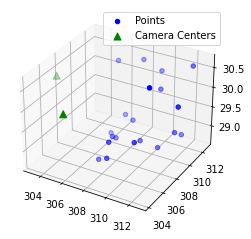

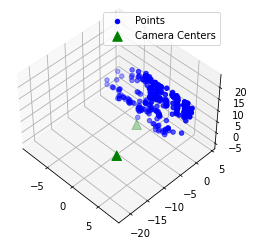

In [42]:
# Write your code here for triangulation
from mpl_toolkits.mplot3d import Axes3D
def triangulation(pts1_2d, pts2_2d, M1, M2):
    """
    Description: triangulate the points in 3D given their 2D correspondences (pts1_2d, pts2_2d) and projection matrices (M1, M2)
        please refer to the equations in the following slides for more details: http://www.cs.cmu.edu/~16385/s17/Slides/11.4_Triangulation.pdf
    Params:
        pts1_2d: np.ndarray with shape (N, 2), features in 2D homogeneous coordinate from the first FOV
        pts3_2d: np.ndarray with shape (N, 2), features in 2D homogeneous coordinate from the second FOV
        M1: np.ndarray with shape (3, 4), a projection matrix corresponding to the first FOV
        M2: np.ndarray with shape (3, 4), a projection matrix corresponding to the second FOV
    Returns:
        pts_3d: np.ndarray with shape (N, 3), features reconstructed from two different FOVs expressed in 3D coordinate
    """
    assert len(pts1_2d) == len(pts2_2d)
    N = len(pts1_2d)

    pts_3d = np.empty((N, 3))

    for i in range(N):
        x1, y1 = pts1_2d[i]
        x2, y2 = pts2_2d[i]
        
        A = np.vstack((y1 * M1[2,:] -      M1[1,:],
                            M1[0,:] - x1 * M1[2,:],
                       y2 * M2[2,:] -      M2[1,:],
                            M2[0,:] - x2 * M2[2,:]))

        # svd composition
        U, S, V = np.linalg.svd(A)

        # reshape the min singular value into a 3d homogeneous coordinate
        pt_3d = np.reshape(V[-1, :], (4,))
        
        # normalize it
        pt_3d /= pt_3d[-1]

        # convert 3d homogeneous representation to be non-homogeneous one
        pts_3d[i] = pt_3d[:-1]
    return pts_3d

def evaluate_points_3d(pts_3d_est, pts_3d_gt):
    """
    write your code to evaluate the triangulated 3D points
    """
    assert len(pts_3d_est) == len(pts_3d_gt)

    N = len(pts_3d_est)
    error_3d = np.empty((N,))
    for i in range(N):
        error_3d[i] = np.linalg.norm(pts_3d_est[i] - pts_3d_gt[i])
    
    return error_3d


# triangulate the 3D point cloud for the lab data 
matches_lab = np.loadtxt('./lab_matches.txt')
lab_pt1 = matches_lab[:,:2]
lab_pt2 = matches_lab[:,2:]
points_3d_gt = np.loadtxt('./lab_3d.txt')

lab_pt1 = matches_lab[:,:2]
lab_pt2 = matches_lab[:,2:]

points_3d_lab = triangulation(lab_pt1, lab_pt2, lab1_proj, lab2_proj) # <YOUR CODE>

res_3d_lab = evaluate_points_3d(points_3d_lab, points_3d_gt) # <YOUR CODE>
print('Mean 3D reconstuction error for the lab data: ', round(np.mean(res_3d_lab), 5))
_, res_2d_lab1 = evaluate_points(lab1_proj, lab_pt1, points_3d_lab)
_, res_2d_lab2 = evaluate_points(lab2_proj, lab_pt2, points_3d_lab)
print('2D reprojection error for the lab 1 data: ', np.mean(res_2d_lab1))
print('2D reprojection error for the lab 2 data: ', np.mean(res_2d_lab2))
# visualization of lab point cloud
camera_centers = np.vstack((lab1_c, lab2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lab[:, 0], points_3d_lab[:, 1], points_3d_lab[:, 2], c='b', label='Points')
ax.scatter(camera_centers[:, 0], camera_centers[:, 1], camera_centers[:, 2], c='g', s=50, marker='^', label='Camera Centers')
ax.legend(loc='best')

# triangulate the 3D point cloud for the library data
matches_lib = np.loadtxt('./library_matches.txt')

lib_pt1 = matches_lib[:,:2]
lib_pt2 = matches_lib[:,2:]

points_3d_lib = triangulation(lib_pt1, lib_pt2, lib1_proj, lib2_proj) # <YOUR CODE>
_, res_2d_lib1 = evaluate_points(lib1_proj, lib_pt1, points_3d_lib)
_, res_2d_lib2 = evaluate_points(lib2_proj, lib_pt2, points_3d_lib)
print('2D reprojection error for the library 1 data: ', np.mean(res_2d_lib1))
print('2D reprojection error for the library 2 data: ', np.mean(res_2d_lib2))
# visualization of library point cloud
camera_centers_library = np.vstack((lib1_c, lib2_c))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d_lib[:, 0], points_3d_lib[:, 1], points_3d_lib[:, 2], c='b', label='Points')
ax.scatter(camera_centers_library[:, 0], camera_centers_library[:, 1], 
           camera_centers_library[:, 2], c='g', s=90, 
           marker='^', label='Camera Centers')
ax.view_init(azim=-45, elev=45)
ax.legend(loc='best')

In [43]:
### extra credits

import cv2
import skimage.io
from scipy.spatial import distance
import scipy

def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def get_best_matches(img1, img2, num_matches=300):
    """
    Descriptions: find putative matches for descriptors in two images
    Inputs:
        img1: first image to investigate
        img2: second image to investigate
        num_matches: number of best matches to find
    Returns:
        pt_pairs: np.ndarray with shape (num_matches, 4)
            where the `num_matches` best matches are listed in an sorted order.
            the first two columns are for pixel coordinates in img1, and the others are corresponding for img2 correspondingly.
    """
    # Get SIFT keypoints and the corresponding descriptors
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in the two images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # From `dist`, find `num_matches` smallest sorted indices
    # `indices` has the size of (num_matches, 2) where each row is (row, col) for `dist`
    indices_raw = dist.ravel().argsort()[:num_matches]
    indices = np.stack(np.unravel_index(indices_raw, dist.shape)).T

    # Find corresponding pixel location in `kp1` and `kp2`
    pt_pairs = np.empty((num_matches, 4))
    for i, idx in enumerate(indices):
        pt_pairs[i, 0:2] = kp1[idx[0]].pt
        pt_pairs[i, 2:4] = kp2[idx[1]].pt

    return pt_pairs

def ransac(pt_pairs, num_iteration=100, threshold=1):
    """
    Descriptions: find homography estimation between two images using RANSAC
    Inputs:
        pt_pairs: np.ndarray with shape (N, 4)
            where the first two columns stand for pixel coordinates for descriptors in img1, and others in img2 correspondinly
        num_iteration: number of iteration for RANSAC (in slide, a variable denoted as `N`)
        threshold: distance threshold for choosing inliers. (in slide, a variable denoted as `\delta`)
    Remark: number of samples (in slide, a variable denoted as `N`) is fixed to be 4 in this implementation
    Returns:
        H: np.ndarray with shape (3, 3)
            where the homography from img1 to img2
        inliers_best: np.ndarray with shape (N_inliers, 4)
            where inliers for `pt_pairs` corresponding to `H`
        inlier_residuals: np.ndarray with shape (N_inliers, )
            where the residuals for `inliers_best`
    """

    ### phase 1. for every iteration...
    # variable to save inliers with the largest population
    inliers_best = np.empty((0,4))
    
    for n in range(num_iteration):
        # choose four points randomly
        candidates = pt_pairs[np.random.choice(pt_pairs.shape[0], 4)]

        # construct a homography candidate
        H = _compute_homography(candidates)
        inliers = np.empty((0,4))

        # estimate inliers for the homography candidate
        for k in range(len(pt_pairs)):
            d = _compute_reproj_error(pt_pairs[k], H)
            if d < threshold:
                inliers = np.append(inliers, pt_pairs[k][np.newaxis], axis=0)
        
        # count inliers and update `inliers_best` if their number exceeds the former
        if len(inliers) > len(inliers_best):
            inliers_best = inliers
    
    ### phase 2. after all iterations are done...
    # refine H
    H = _compute_homography(inliers_best)

    # update corresponding inliers again and construct model errors
    inliers_best = np.empty((0,4))
    inlier_residuals = np.empty((0,))
    for k in range(len(pt_pairs)):
        d = _compute_reproj_error(pt_pairs[k], H)
        if d < threshold:
            inliers_best = np.append(inliers_best, pt_pairs[k][np.newaxis], axis=0)
            inlier_residuals = np.append(inlier_residuals, d)

    return H, inliers_best, inlier_residuals

def _compute_reproj_error(pt_pair, H):
    """
    Descriptions: compute reprojection error of a given point pair for the given homography H
    Inputs:
        pt_pairs: np.ndarray with shape (4, )
            where the first two entries stand for pixel coordinates for descriptors in img1, and others in img2 correspondinly
        H: np.ndarray with shape (3, 3)
            where the homography from img1 to img2
    Returns:
        np.linalg.norm(error): residual from the original point w.r.t. the other projected by H
    """
    # construct homogeneous coordinates for the point pair in two images
    x0 = np.append(pt_pair[:2], 1)
    x1 = np.append(pt_pair[2:], 1)
    
    # project x0 onto the image of X1 by the given homography H
    x1_proj = np.dot(H, x0)
    x1_proj /= x1_proj[-1]

    # compute the reprojection error
    error = x1 - x1_proj
    return np.linalg.norm(error)

def _compute_homography(pt_pairs):
    """
      param pt_pairs : (N, 4) shape np.array whose rows are of (pt1, pt2) correspondingly
      return H : (3, 3) shape np.array for estimated matrix
    """
    assert len(pt_pairs) >= 4

    # construct matrix equation Ap = 0 to solve the homography
    A = np.empty((0, 9))
    for pt in pt_pairs:
        x0 = np.append(pt[:2], 1)
        x1 = np.append(pt[2:], 1)
        A = np.append(A, np.concatenate([np.zeros(3), x0, -x1[1] * x0])[np.newaxis], axis=0)
        A = np.append(A, np.concatenate([x0, np.zeros(3), -x1[0] * x0])[np.newaxis], axis=0)
    
    #svd composition
    U, S, V = np.linalg.svd(A)

    #reshape the min singular value into a 3 by 3 matrix
    H = np.reshape(V[-1, :], (3, 3))

    #normalize and now we have H
    H /= H[-1, -1]
    return H

Average residual: 3.18
Inlier ratio: 0.36


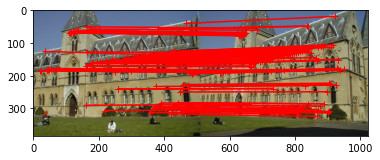

In [44]:
# Fundamental matrix estimation
name = 'library' 
# You also need to report results for name = 'lab'
# name = 'lab'

I1 = imread('./{:s}1.jpg'.format(name))
I2 = imread('./{:s}2.jpg'.format(name))

# matches between img1 and img2
matches_raw = get_best_matches(I1, I2, 300)
H, matches, residuals = ransac(matches_raw, num_iteration=100, threshold=10)
print(f"Average residual: {np.average(residuals):.2f}")
print(f"Inlier ratio: {len(matches) / len(matches_raw):.2f}")

N = len(matches);

## Display two images side-by-side with matches
## this code is to help you visualize the matches, you don't need
## to use it to produce the results for the assignment
I3 = np.zeros((I1.shape[0],I1.shape[1]*2,3))
I3[:,:I1.shape[1],:] = I1;
I3[:,I1.shape[1]:,:] = I2;
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(matches[:,0],matches[:,1],  '+r')
ax.plot( matches[:,2]+I1.shape[1],matches[:,3], '+r')
ax.plot([matches[:,0], matches[:,2]+I1.shape[1]],[matches[:,1], matches[:,3]], 'r')
ax.imshow(np.array(I3).astype(np.uint8))
plt.savefig('./{:s}_matches_ransac.jpg'.format(name))


library: residual in frame 2 (from RANSAC, normalized method) =  3.19344289509685
library: residual in frame 1 (from RANSAC, normalized method) =  3.082044571984978
library: residual combined   (from RANSAC, normalized method) =  3.1377437335409137


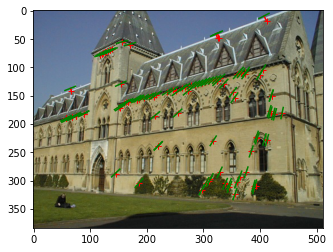

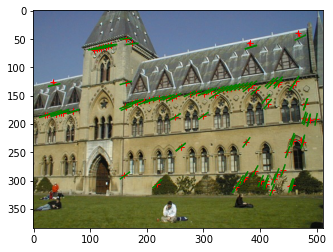

In [45]:
# normalized method
pt1_2d = matches[:, :2]
pt2_2d = matches[:, 2:]

F = fit_fundamental_normalized(pt1_2d, pt2_2d) # <YOUR CODE>
v2 = get_residual(F, pt1_2d, pt2_2d)
v1 = get_residual(F.T, pt2_2d, pt1_2d)
print('{:s}: residual in frame 2 (from RANSAC, normalized method) = '.format(name), v2)
print('{:s}: residual in frame 1 (from RANSAC, normalized method) = '.format(name), v1)
print('{:s}: residual combined   (from RANSAC, normalized method) = '.format(name), (v1+v2)/2)
# Plot epipolar lines in image I2
fig, ax = plt.subplots()
plot_fundamental(ax, F, pt1_2d, pt2_2d, I2)
plt.savefig('./{:s}2_normalized_ransac.jpg'.format(name))
# Plot epipolar lines in image I1
fig, ax = plt.subplots()
plot_fundamental(ax, F.T, pt2_2d, pt1_2d, I1)
plt.savefig('./{:s}1_normalized_ransac.jpg'.format(name))